# PCA analysis number of components needed to preserve diffusion

Lets look to the fiber segments phantom principal components when noise is added

In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from pca_utils import (rfiw_phantom, mp_distribution, fiber_segments_phantom)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

Lets generated the phantom

In [3]:
fsigma = 20.0
Phantom = fiber_segments_phantom(gtab, fsigma)

Add noise

In [4]:
from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)
snr = 15
sigma = 50.0 /snr
n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
PDen = _add_rician(Phantom.copy(), n1, n2)

Look to eigenvalues of one voxel

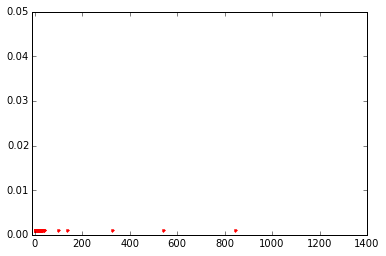

In [5]:
psize = 2
m = (2*psize + 1) ** 3
n = PDen.shape[3]
k = j = i = 2
X = PDen[i - psize: i + psize + 1, j - psize: j + psize + 1,
         k - psize: k + psize + 1, :]
X = X.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
[L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

y = n*1.0/m
x = np.linspace(0, 500, num=100)
plt.plot(L, 0.001*np.ones(L.shape), '.r')
plt.axis([-10, 1400, 0, 0.05])
plt.show()

(1.0087369733269114, 6)


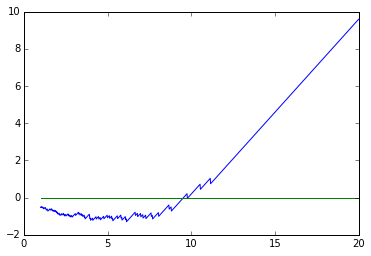

In [6]:
def mp_var_likelihood(x, var, y):
    xpos = var*(1+np.sqrt(y))**2
    #p = mp_distribution(x, var, y)
    return var - np.mean(x[x<xpos]), np.sum(x>xpos)
print mp_var_likelihood(L, sigma ** 2, y)

var_samples = np.linspace(1, 20, num=1000)
rmp_samples = np.empty(var_samples.shape)
nretain = np.empty(var_samples.shape)

for i in range(var_samples.size):
    rmp_samples[i], nretain[i] = mp_var_likelihood(L, var_samples[i], y)
plt.plot(var_samples, rmp_samples, var_samples, np.zeros(var_samples.shape))
plt.show()

In [7]:
print mp_var_likelihood(L, 9.6, y)

(0.060087446138075151, 8)


In [8]:
np.sqrt(9.807)

3.1316130029108002

In [9]:
sigma ** 2

11.111111111111112

Now lets analyse what is the idea number of PCA components to take into account to robustly remove noise however perserving diffusion weigthted directions.

Lets first define the dti and dki models.

In [10]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

Define the functions to evaluate the measures

In [11]:
def evaluate_directions(directions, gtdirections):
    angle = np.zeros(directions.shape[0:3])
    for i in range(directions.shape[0]):
        for j in range(directions.shape[1]):
            for k in range(directions.shape[0]):
                v1 = directions[i, j, k]
                vr = gtdirections[i, j, k]
                angle[i, j, k] = np.arccos(np.abs(v1.dot(vr.T))) * 180.0 / np.pi
    p1, p2, p3 = np.percentile(angle, [25 , 50, 75])
    return p2, p2 - p1, p3 - p2

def evaluate_metric(m, gtm):
    err = m - gtm
    p1, p2, p3 = np.percentile(err, [25, 50, 75])
    return p2, p2 - p1, p3 - p2

Define localpca

In [12]:
def localpca(DWI, psize, nep):
    # nep number of elements preserved
    m = (2*psize + 1) ** 3
    n = DWI.shape[3]
    DWIden = np.zeros(DWI.shape)
    for k in range(psize, DWI.shape[2] - psize):
        for j in range(psize, DWI.shape[1] - psize):
            for i in range(psize, DWI.shape[0] - psize):
                X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
                        k - psize: k + psize + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
                Y = X.dot(W[:, -nep:])
                X = Y.dot(W[:, -nep:].T)
                X = X + M
                X = X.reshape(2*psize + 1, 2*psize + 1, 2*psize + 1, n)
                DWIden[i, j, k, :] = X[psize, psize, psize]
    return DWIden

In [14]:
# initialize
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
neps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 25, 30, 40, 50, 70, 90, 104])
dir1 = np.zeros((neps.size, fsigmas.size))
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)

for p in range(4):
    # ground truth
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])
    dtiFgt = dtiM.fit(Phantom)
    FAgt = dtiFgt.fa
    MDgt = dtiFgt.md 
    directionsgt = dtiFgt.directions
    dkiFgt = dkiM.fit(Phantom)
    MKgt = dkiFgt.mk()

    # add noise
    snr = 15
    sigma = 50.0 /snr
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)
    
    # denoise and compare
    for r in range(neps.size):
        Pden = localpca(Phantom_noise.copy(), 2, neps[r])
        dtiF = dtiM.fit(Pden)
        FA = dtiF.fa
        MD = dtiF.md
        directions = dtiF.directions
        dkiF = dkiM.fit(Pden)
        MK = dkiF.mk()
        p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])
        dir1[r, p] = p1
        dir2[r, p] = p2
        dir3[r, p] = p3
        p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])
        fa1[r, p] = p1
        fa2[r, p] = p2
        fa3[r, p] = p3
        p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], MDgt[2:-2, 2:-2, 2:-2])
        md1[r, p] = p1
        md2[r, p] = p2
        md3[r, p] = p3
        p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], MKgt[2:-2, 2:-2, 2:-2])
        mk1[r, p] = p1
        mk2[r, p] = p2
        mk3[r, p] = p3
        print r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


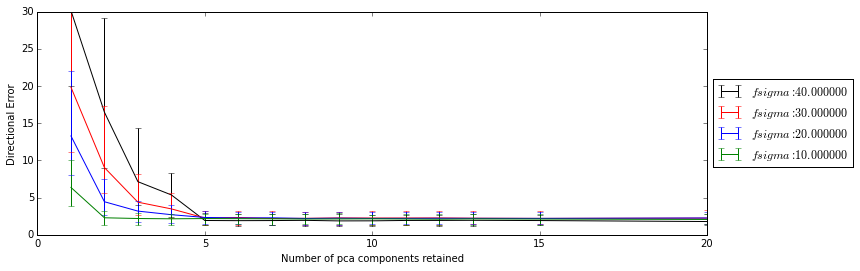

In [16]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, dir1[:, p], yerr=[dir2[:, p], dir3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 20, 0, 30])
plt.xlabel('Number of pca components retained')
plt.ylabel('Directional Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()
plt.show()

Directional error is reduced when more 5 PCA components are preserved.

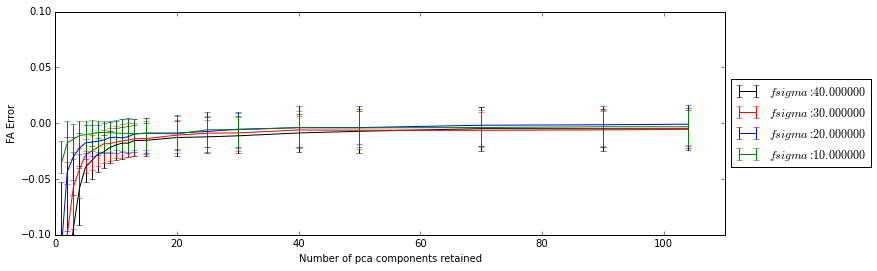

In [18]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, fa1[:, p], yerr=[fa2[:, p], fa3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.xlabel('Number of pca components retained')
plt.ylabel('FA Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis([0, 110, -0.1, 0.1])
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()

FA variance seem smaller when around 15 components are preserved. 

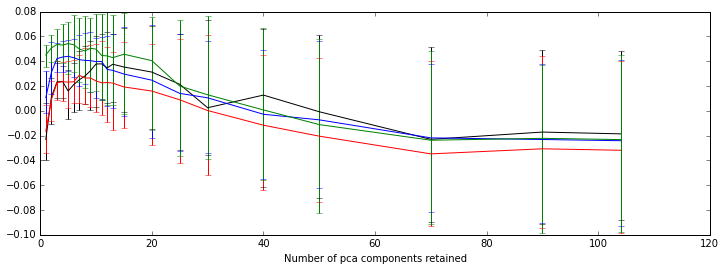

In [19]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, mk1[:, p], yerr=[mk2[:, p], mk3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.xlabel('Number of pca components retained')
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()

MK variance is also lower when around 15 are preserved however it associated median values are overestimated. This might be an overestimation effect of the Rician nature of noise (see pca analysos part 2).

# Additional figures

In [20]:
from dipy.reconst.dti import color_fa
from dipy.viz import fvtk
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [21]:
Phantom = fiber_segments_phantom(gtab, 20)

dtiFgt = dtiM.fit(Phantom)
FAgt = dtiFgt.fa
MDgt = dtiFgt.md 
directionsgt = dtiFgt.directions
dkiFgt = dkiM.fit(Phantom)
MKgt = dkiFgt.mk()
evalsgt = dtiFgt.evals
evecsgt = dtiFgt.evecs

RGBgt = color_fa(FAgt, evecsgt)

ren = fvtk.ren()

evalsgt3 = evalsgt[:, :, 3:4]
evecsgt3 = evecsgt[:, :, 3:4]

cfagt = RGBgt[:, :, 3:4]

fvtk.add(ren, fvtk.tensor(evalsgt3, evecsgt3, cfagt, sphere))

#print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids_gt.png', size=(600, 600))

In [22]:
fvtk.show(ren, size=(600, 600))

In [23]:
snr = 15
sigma = 50.0 /snr
n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

dtiFnoise = dtiM.fit(Phantom_noise)
FAnoise = dtiFnoise.fa
MDnoise = dtiFnoise.md 
directionsnoise = dtiFnoise.directions
dkiFnoise = dkiM.fit(Phantom_noise)
MKnoise = dkiFnoise.mk()
evalsnoise = dtiFnoise.evals
evecsnoise = dtiFnoise.evecs

RGBnoise = color_fa(FAnoise, evecsnoise)

ren = fvtk.ren()

evalsnoise3 = evalsnoise[:, :, 3:4]
evecsnoise3 = evecsnoise[:, :, 3:4]

cfanoise = RGBgt[:, :, 3:4]

fvtk.add(ren, fvtk.tensor(evalsnoise3, evecsnoise3, cfanoise, sphere))

#print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids_noise.png', size=(600, 600))

In [24]:
fvtk.show(ren, size=(600, 600))

In [25]:
Pden = localpca(Phantom_noise.copy(), 2, 10)
dtiFden = dtiM.fit(Pden)
FAden = dtiFden.fa
MDden = dtiFden.md 
directionsden = dtiFden.directions
dkiFden = dkiM.fit(Pden)
MKden = dkiFden.mk()
evalsden = dtiFden.evals
evecsden = dtiFden.evecs

RGBden = color_fa(FAden, evecsden)

ren = fvtk.ren()

evalsden3 = evalsden[:, :, 3:4]
evecsden3 = evecsden[:, :, 3:4]

cfaden = RGBgt[:, :, 3:4]

fvtk.add(ren, fvtk.tensor(evalsden3, evecsden3, cfaden, sphere))

#print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids_den.png', size=(600, 600))

In [26]:
fvtk.show(ren, size=(600, 600))

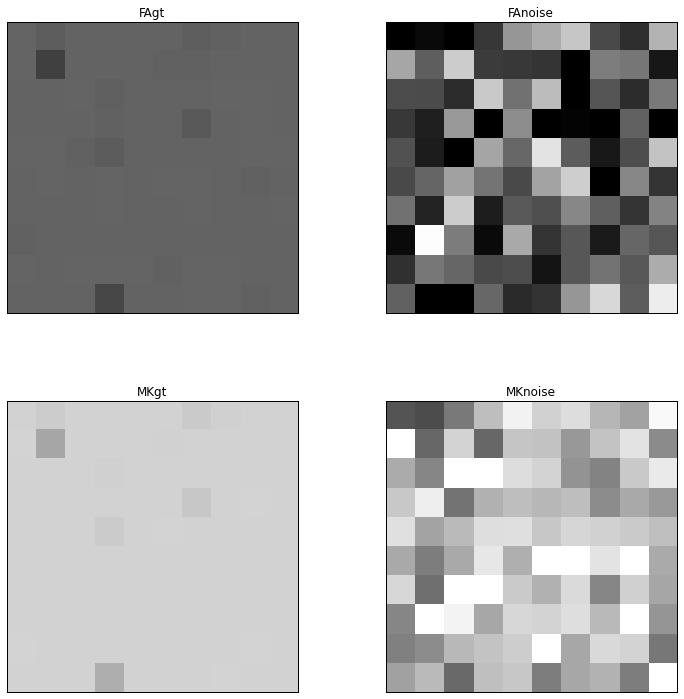

In [27]:
fig2, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

ax.flat[0].imshow(FAgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[0].set_title('FAgt')
ax.flat[1].imshow(FAnoise[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[1].set_title('FAnoise')
ax.flat[2].imshow(MKgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[2].set_title('MKgt')
ax.flat[3].imshow(MKnoise[:, :, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[3].set_title('MKnoise')
plt.show()

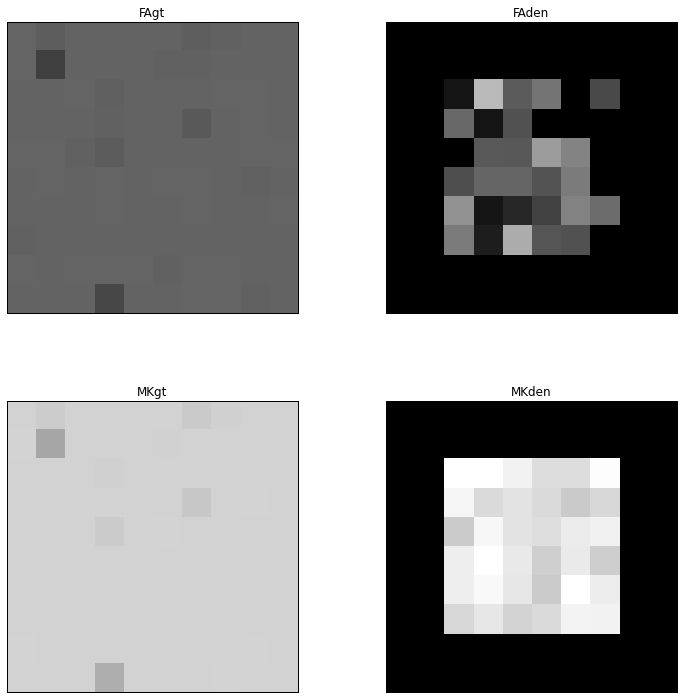

In [28]:
fig2, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

ax.flat[0].imshow(FAgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[0].set_title('FAgt')
ax.flat[1].imshow(FAden[:, :, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[1].set_title('FAden')
ax.flat[2].imshow(MKgt[:, :, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[2].set_title('MKgt')
ax.flat[3].imshow(MKden[:, :, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[3].set_title('MKden')
plt.show()

In [29]:
np.std(MKgt)

0.010067028451276338

In [30]:
np.std(MKnoise)

0.0997636559890063

In [31]:
np.std(MKden[MKden>0])

0.036783565444695403

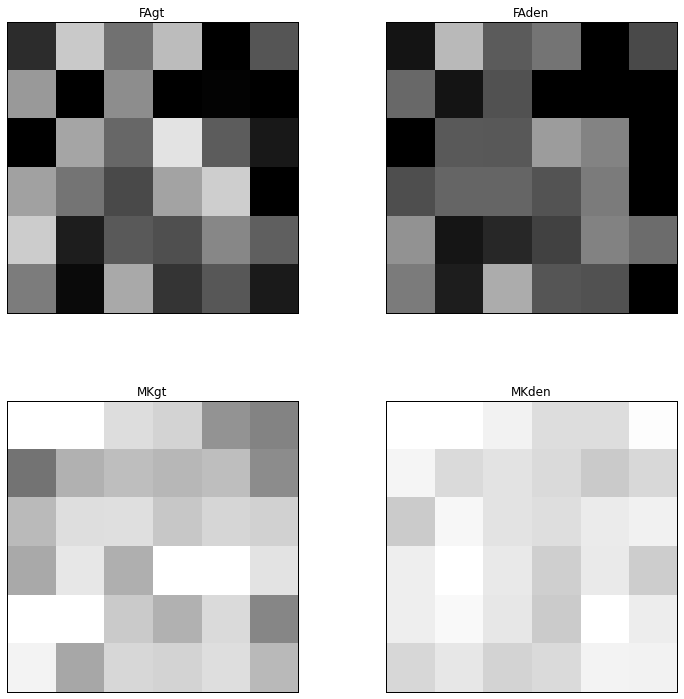

In [32]:
fig2, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

ax.flat[0].imshow(FAnoise[2:-2, 2:-2, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[0].set_title('FAgt')
ax.flat[1].imshow(FAden[2:-2, 2:-2, 3], cmap='gray', interpolation="nearest", clim=(0.8, 0.9))
ax.flat[1].set_title('FAden')
ax.flat[2].imshow(MKnoise[2:-2, 2:-2, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[2].set_title('MKgt')
ax.flat[3].imshow(MKden[2:-2, 2:-2, 3], cmap='gray', interpolation="nearest", clim=(1.2, 1.7))
ax.flat[3].set_title('MKden')
plt.show()